# Project: Investigate a Dataset – TMDb Movie Data

## Table of Contents
- [Introduction](#intro)
- [Data Wrangling](#data-wrangling)
- [Exploratory Data Analysis](#exploratory-data-analysis)
- [Conclusions](#conclusions)


# <a id='intro'></a>
## Introduction

### Dataset Description 

This dataset, sourced from The Movie Database (TMDb), contains metadata for 10,866 movies released over multiple decades. It was selected for exploratory analysis as part of the "Investigate a Dataset" project in the Udacity Data Analyst Nanodegree.

Each row represents a single film and includes a range of attributes related to its popularity, production, ratings, and creative elements; providing rich insights into storytelling trends and audience reception.

---

### Dataset Structure

The dataset includes one primary table with the following columns:

| Column Name              | Description                                                                 |
|--------------------------|------------------------------------------------------------------------------|
| `id`                     | Unique identifier for each movie entry                                      |
| `imdb_id`                | IMDb identifier for reference                                                |
| `popularity`             | Popularity score on TMDb                                                     |
| `budget`                 | Production budget in USD                                                     |
| `revenue`                | Box office revenue in USD                                                    |
| `original_title`         | Original title of the movie                                                  |
| `cast`                   | List of main cast members                                                    |
| `homepage`               | Official homepage URL (if available)                                        |
| `director`               | Director of the movie                                                        |
| `tagline`                | Promotional slogan or catchphrase                                           |
| `keywords`               | Descriptive keywords or themes                                               |
| `overview`               | Brief plot summary                                                           |
| `runtime`                | Duration of the movie (in minutes)                                           |
| `genres`                 | One or more genre labels (e.g., Action, Drama)                              |
| `production_companies`   | Companies involved in production                                              |
| `release_date`           | Release date of the movie                                                    |
| `vote_count`             | Number of user votes on TMDb                                                 |
| `vote_average`           | Average rating received from users                                           |
| `release_year`           | Year of release (extracted from `release_date`)                              |
| `budget_adj`             | Inflation-adjusted budget                                                    |
| `revenue_adj`            | Inflation-adjusted revenue                                                   |

---


### Questions for Analysis
<li> Which genres are most associated with cult-classic movies in the TMDb dataset? 
<li> Which actors appear the most in cult-classic films?


### Working Definition of a "Cult-Classic" movie
- Low initial popularity or revenue (when compared to 'Blockbusters')
- High vote average despite lower vote count (suggests niche but passionate fanbase)
- Unusual or standout keywords (e.g. “time travel”, “anti-hero”, “dark comedy”)
- Unique tagline or overview that hints at offbeat themes

## Cult Score Components
- High ratings → good movie quality
- Low vote count → niche, not many people have rated it
- Low popularity → not a mainstream hit

### Cult Score Formula (Conceptual)
cult_score = vote_average - (vote_count / 1000) - (popularity / 10) <br>
>_note: this is where I started, I make an adjustment later based on learnings_

#### Component Breakdown
- vote_average: This reflects how positively the movie was rated. A high value boosts the Cult Score.
- vote_count / 1000: Dividing by 1000 scales down the number of ratings. More votes usually suggest mainstream popularity, so this subtracts from the score.
- popularity / 10: This scales the popularity metric. Highly popular films get penalized because cult classics tend to be under the radar.

In [50]:
### Imports

In [51]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

<a id='wrangling'></a>
## Data Wrangling

### Loading in the data and printing out some basic details

__What is the size of the data frame?(index and column count)__ <br>
__What data types are present?__

In [52]:
df = pd.read_csv('/workspace/Database_TMDb_movie_data/tmdb-movies.csv')

In [53]:
print('data info') 
print(df.info())

data info
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10866 entries, 0 to 10865
Data columns (total 21 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   id                    10866 non-null  int64  
 1   imdb_id               10856 non-null  object 
 2   popularity            10866 non-null  float64
 3   budget                10866 non-null  int64  
 4   revenue               10866 non-null  int64  
 5   original_title        10866 non-null  object 
 6   cast                  10790 non-null  object 
 7   homepage              2936 non-null   object 
 8   director              10822 non-null  object 
 9   tagline               8042 non-null   object 
 10  keywords              9373 non-null   object 
 11  overview              10862 non-null  object 
 12  runtime               10866 non-null  int64  
 13  genres                10843 non-null  object 
 14  production_companies  9836 non-null   object 
 15  release_d

***
__What are some basic statistics on the data frame?__

In [54]:
print('describe') 
print(df.describe())

describe
                  id    popularity        budget       revenue       runtime  \
count   10866.000000  10866.000000  1.086600e+04  1.086600e+04  10866.000000   
mean    66064.177434      0.646441  1.462570e+07  3.982332e+07    102.070863   
std     92130.136561      1.000185  3.091321e+07  1.170035e+08     31.381405   
min         5.000000      0.000065  0.000000e+00  0.000000e+00      0.000000   
25%     10596.250000      0.207583  0.000000e+00  0.000000e+00     90.000000   
50%     20669.000000      0.383856  0.000000e+00  0.000000e+00     99.000000   
75%     75610.000000      0.713817  1.500000e+07  2.400000e+07    111.000000   
max    417859.000000     32.985763  4.250000e+08  2.781506e+09    900.000000   

         vote_count  vote_average  release_year    budget_adj   revenue_adj  
count  10866.000000  10866.000000  10866.000000  1.086600e+04  1.086600e+04  
mean     217.389748      5.974922   2001.322658  1.755104e+07  5.136436e+07  
std      575.619058      0.935142   

***
__What are the number of unique entries per column?__

In [55]:
print('number of unique') 
print(df.nunique())

number of unique
id                      10865
imdb_id                 10855
popularity              10814
budget                    557
revenue                  4702
original_title          10571
cast                    10719
homepage                 2896
director                 5067
tagline                  7997
keywords                 8804
overview                10847
runtime                   247
genres                   2039
production_companies     7445
release_date             5909
vote_count               1289
vote_average               72
release_year               56
budget_adj               2614
revenue_adj              4840
dtype: int64


### Data Cleaning 

#### A couple of columns contain null values that could affect my analysis
> tagline, genres, and keywords namely, but there are several more

__Generate a list of columns containing null values__

In [56]:
df.isnull().sum().sort_values(ascending=False)

homepage                7930
tagline                 2824
keywords                1493
production_companies    1030
cast                      76
director                  44
genres                    23
imdb_id                   10
overview                   4
budget_adj                 0
release_year               0
vote_average               0
vote_count                 0
release_date               0
id                         0
runtime                    0
original_title             0
revenue                    0
budget                     0
popularity                 0
revenue_adj                0
dtype: int64

#### Since I care about `Genres` and `keywords` I am going to drop rows where either is missing

In [57]:
df = df.dropna(subset=['genres', 'keywords'])
remaining_rows = len(df)
print(f"Remaining rows: {remaining_rows}")

Remaining rows: 9368


#### Checking for Duplicated rows and removing any identified

In [58]:
# Find all duplicated rows (entire row matches another)
duplicate_rows = df[df.duplicated(keep=False)]

# Display count
remaining_rows = {len(duplicate_rows)}
print(f"Number of duplicate rows: {len(duplicate_rows)}")
print()

# Preview duplicated entries
print(duplicate_rows.head())


Number of duplicate rows: 2

         id    imdb_id  popularity    budget  revenue original_title  \
2089  42194  tt0411951     0.59643  30000000   967000         TEKKEN   
2090  42194  tt0411951     0.59643  30000000   967000         TEKKEN   

                                                   cast homepage  \
2089  Jon Foo|Kelly Overton|Cary-Hiroyuki Tagawa|Ian...      NaN   
2090  Jon Foo|Kelly Overton|Cary-Hiroyuki Tagawa|Ian...      NaN   

              director              tagline  ...  \
2089  Dwight H. Little  Survival is no game  ...   
2090  Dwight H. Little  Survival is no game  ...   

                                               overview runtime  \
2089  In the year of 2039, after World Wars destroy ...      92   
2090  In the year of 2039, after World Wars destroy ...      92   

                                           genres    production_companies  \
2089  Crime|Drama|Action|Thriller|Science Fiction  Namco|Light Song Films   
2090  Crime|Drama|Action|Thriller|Sc

In [59]:
# removing identified duplicates
df = df.drop_duplicates()

# Verifying duplicates are removed
duplicate_rows = df[df.duplicated(keep=False)]
print(f"Remaining rows: {remaining_rows}")


Remaining rows: {2}


### Stringified Lists
> Columns such as: `cast`, `keywords`, and `genres` contain lists of values in string format.
    

In [60]:
#show the columns with stringified lists
df[['cast','keywords','genres']] 


,cast,keywords,genres
0,Chris Pratt|Bryce Dallas Howard|Irrfan Khan|Vi...,monster|dna|tyrannosaurus rex|velociraptor|island,Action|Adventure|Science Fiction|Thriller
1,Tom Hardy|Charlize Theron|Hugh Keays-Byrne|Nic...,future|chase|post-apocalyptic|dystopia|australia,Action|Adventure|Science Fiction|Thriller
2,Shailene Woodley|Theo James|Kate Winslet|Ansel...,based on novel|revolution|dystopia|sequel|dyst...,Adventure|Science Fiction|Thriller
3,Harrison Ford|Mark Hamill|Carrie Fisher|Adam D...,android|spaceship|jedi|space opera|3d,Action|Adventure|Science Fiction|Fantasy
4,Vin Diesel|Paul Walker|Jason Statham|Michelle ...,car race|speed|revenge|suspense|car,Action|Crime|Thriller
...,...,...,...
10861,Michael Hynson|Robert August|Lord 'Tally Ho' B...,surfer|surfboard|surfing,Documentary
10862,James Garner|Eva Marie Saint|Yves Montand|Tosh...,car race|racing|formula 1,Action|Adventure|Drama
10863,Innokentiy Smoktunovskiy|Oleg Efremov|Georgi Z...,car|trolley|stealing car,Mystery|Comedy
10864,Tatsuya Mihashi|Akiko Wakabayashi|Mie Hama|Joh...,spoof,Action|Comedy


__Converting the strings into lists__

In [61]:
# Split keywords strings into lists
df['cast_list'] = df['cast'].str.split('|')

# Split keywords strings into lists
df['keywords_list'] = df['keywords'].str.split('|')

# Split genre strings into lists
df['genres_list'] = df['genres'].str.split('|')

#### Display cast list

In [62]:
df['cast_list']

0        [Chris Pratt, Bryce Dallas Howard, Irrfan Khan...
1        [Tom Hardy, Charlize Theron, Hugh Keays-Byrne,...
2        [Shailene Woodley, Theo James, Kate Winslet, A...
3        [Harrison Ford, Mark Hamill, Carrie Fisher, Ad...
4        [Vin Diesel, Paul Walker, Jason Statham, Miche...
                               ...                        
10861    [Michael Hynson, Robert August, Lord 'Tally Ho...
10862    [James Garner, Eva Marie Saint, Yves Montand, ...
10863    [Innokentiy Smoktunovskiy, Oleg Efremov, Georg...
10864    [Tatsuya Mihashi, Akiko Wakabayashi, Mie Hama,...
10865    [Harold P. Warren, Tom Neyman, John Reynolds, ...
Name: cast_list, Length: 9367, dtype: object

#### Display keyword list

In [63]:
df['keywords_list']

0        [monster, dna, tyrannosaurus rex, velociraptor...
1        [future, chase, post-apocalyptic, dystopia, au...
2        [based on novel, revolution, dystopia, sequel,...
3              [android, spaceship, jedi, space opera, 3d]
4                [car race, speed, revenge, suspense, car]
                               ...                        
10861                         [surfer, surfboard, surfing]
10862                        [car race, racing, formula 1]
10863                         [car, trolley, stealing car]
10864                                              [spoof]
10865            [fire, gun, drive, sacrifice, flashlight]
Name: keywords_list, Length: 9367, dtype: object

#### Display genres list

In [64]:
df['genres_list']

0        [Action, Adventure, Science Fiction, Thriller]
1        [Action, Adventure, Science Fiction, Thriller]
2                [Adventure, Science Fiction, Thriller]
3         [Action, Adventure, Science Fiction, Fantasy]
4                             [Action, Crime, Thriller]
                              ...                      
10861                                     [Documentary]
10862                        [Action, Adventure, Drama]
10863                                 [Mystery, Comedy]
10864                                  [Action, Comedy]
10865                                          [Horror]
Name: genres_list, Length: 9367, dtype: object

__There are outliers in the numeric columns `budget`, `budget_adj`, and `revenue`.__ <br>
_The adjusted values also contains many zero's meaning there's incomplete data_

In [65]:

df[['budget','budget_adj', 'revenue']]

,budget,budget_adj,revenue
0,150000000,1.379999e+08,1513528810
1,150000000,1.379999e+08,378436354
2,110000000,1.012000e+08,295238201
3,200000000,1.839999e+08,2068178225
4,190000000,1.747999e+08,1506249360
...,...,...,...
10861,0,0.000000e+00,0
10862,0,0.000000e+00,0
10863,0,0.000000e+00,0
10864,0,0.000000e+00,0


__Replacing zeros with NaN and removing them__

In [66]:
# Display how many rows have missing numeric values before cleaning
key_numeric_cols = ['budget', 'revenue', 'budget_adj', 'revenue_adj', 'runtime']
missing_counts = df[key_numeric_cols].isnull().sum()
print("Missing values before cleaning:\n", missing_counts)

Missing values before cleaning:
 budget         0
revenue        0
budget_adj     0
revenue_adj    0
runtime        0
dtype: int64


In [67]:
# Replace zero values in budget and revenue with NaN (common placeholder for missing)
df[['budget', 'revenue', 'budget_adj', 'revenue_adj']] = df[
    ['budget', 'revenue', 'budget_adj', 'revenue_adj']
].replace(0, np.nan)

# Drop rows where any of the key numeric columns are NaN
df_cleaned = df.dropna(subset=key_numeric_cols)

# Show how many rows were dropped
rows_dropped = len(df) - len(df_cleaned)
print(f"\nRows dropped: {rows_dropped}")
print(f"Remaining rows: {len(df_cleaned)}")


Rows dropped: 5651
Remaining rows: 3716


<a id='eda'></a>
## Exploratory Data Analysis

> **Tip**: Now that you've trimmed and cleaned your data, you're ready to move on to exploration. **Compute statistics** and **create visualizations** with the goal of addressing the research questions that you posed in the Introduction section. You should compute the relevant statistics throughout the analysis when an inference is made about the data. Note that at least two or more kinds of plots should be created as part of the exploration, and you must  compare and show trends in the varied visualizations. Remember to utilize the visualizations that the pandas library already has available.



> **Tip**: Investigate the stated question(s) from multiple angles. It is recommended that you be systematic with your approach. Look at one variable at a time, and then follow it up by looking at relationships between variables. You should explore at least three variables in relation to the primary question. This can be an exploratory relationship between three variables of interest, or looking at how two independent variables relate to a single dependent variable of interest. Lastly, you  should perform both single-variable (1d) and multiple-variable (2d) explorations.


### Research Question 1 (Which Genres have the most cult classic movies?)

__Add the 'Cult Score' Column__

_I realized the age of the film affects the formula.  I'm addressing that issue below._

In [68]:
df['release_year'] = pd.to_datetime(df['release_date'], errors='coerce').dt.year
df['years_since_release'] = 2025 - df['release_year']


In [69]:
df['cult_score'] = (
    df['vote_average']
    - (df['vote_count'] / 1000)
    - (df['popularity'] / 10)
    + (df['years_since_release'] / 10)
)


In [70]:
df[['original_title', 'cult_score']].sort_values(by='cult_score', ascending=False)

,original_title,cult_score
8411,Queen - Rock Montreal,12.855709
10817,The Last Waltz,12.660597
7948,Stop Making Sense,12.448681
1385,Emmet Otter's Jug-Band Christmas,12.289754
9847,Boss Nigger,12.275435
...,...,...
7269,The Godfather,-0.943803
4361,The Avengers,-1.066777
1919,Inception,-1.303364
0,Jurassic World,-1.360576


In [71]:
# Set Cult Score threshold (top 5%)
threshold = df['cult_score'].quantile(0.95)

In [72]:
# Filter cult movies and create a clean copy
cult_movies = df[df['cult_score'] >= threshold].copy()

# Save title + score to CSV for later use
cult_movies[['original_title', 'cult_score']].to_csv('cult_score_table.csv', index=False)

# Print number of cult films
print(f"Cult movie count: {len(cult_movies)}")

Cult movie count: 469


In [73]:
# Ensure genre_list is usable and explode it
cult_movies = cult_movies.copy()
cult_movies['genres_list'] = cult_movies['genres_list'].astype(str).str.strip("[]").str.replace("'", "").str.split(', ')
cult_movies_exploded = cult_movies.explode('genres_list')


In [74]:
# Count number of cult movies per genre
cult_genre_counts = cult_movies_exploded['genres_list'].value_counts()


In [75]:
# Write a reusable function for creating bar charts
def plot_horizontal_bar(data, title='Bar Chart', xlabel='Count', ylabel='Category', figsize=(8,6)):
    """
    Reusable function to plot a horizontal bar chart.

    Parameters:
    - data: A pandas Series or dictionary with categorical keys and numeric values
    - title: Chart title (str)
    - xlabel: Label for x-axis (str)
    - ylabel: Label for y-axis (str)
    - figsize: Tuple defining the figure size (width, height)
    """
    plt.figure(figsize=figsize)
    data.sort_values().plot.barh()
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.tight_layout()
    plt.show()


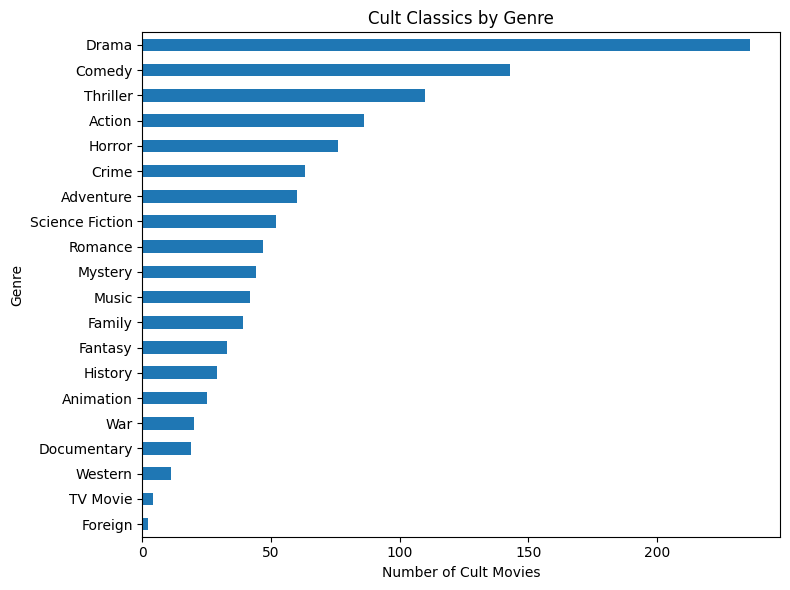

In [76]:
# Display results
plot_horizontal_bar(
    data=cult_genre_counts,
    title='Cult Classics by Genre',
    xlabel='Number of Cult Movies',
    ylabel='Genre'
)


__Since 'Drama' is applied so broadly, I built a genre lift table to compare which genres are overrepresented in Cult Classics relative to the full dataset.__

In [77]:
# Count genres in full set
df['genres_list'] = df['genres'].str.split('|')
df_exploded = df.explode('genres_list')

cult_movies['genres_list'] = cult_movies['genres'].str.split('|')
cult_movies_exploded = cult_movies.explode('genres_list')

full_genre_counts = df_exploded['genres_list'].value_counts(normalize=True)

# Count genres in cult set
cult_genre_counts = cult_movies_exploded['genres_list'].value_counts(normalize=True)

# Merge and calculate lift
genre_lift = pd.DataFrame({
    'full_pct': full_genre_counts,
    'cult_pct': cult_genre_counts
})
genre_lift['lift'] = genre_lift['cult_pct'] / genre_lift['full_pct']
genre_lift = genre_lift.sort_values(by='lift', ascending=False)

# Show top lifts
genre_lift.head(10)  



,full_pct,cult_pct,lift
Music,0.015148,0.036810,2.430065
History,0.012947,0.025416,1.963036
War,0.010324,0.017528,1.697820
Western,0.006601,0.009641,1.460561
Mystery,0.030888,0.038563,1.248479
Drama,0.178091,0.206836,1.161408
Horror,0.059998,0.066608,1.110169
Crime,0.052467,0.055215,1.052375
Science Fiction,0.046205,0.045574,0.986353
Documentary,0.017136,0.016652,0.971740


#### Genre Lift Observations

- Music shows the strongest lift at 2.43. Even though it’s not a major genre in the full dataset, it's clearly overrepresented among cult films. That suggests musical narratives, concert footage, or artist-driven stories may be getting extra traction with niche audiences.
- Historical films have a lift close to 2.0, which is higher than expected based on how often they appear in general. This may point to specific titles that reinterpret real events or carry deeper cultural relevance.
- War films come in near 1.70. That could be tied to stylized war dramas or psychologically intense stories that resonate beyond traditional genre boundaries.
- Westerns post a lift of 1.46. They’re not dominant overall, but something about unconventional or retro westerns may be helping them stand out in the cult space.
- Mystery hits 1.25. That tells me people are gravitating toward stories with unresolved tension, ambiguity, or unusual structure. These elements likely contribute to long-term fan engagement.
- Drama lands at 1.16. It’s the most common genre overall, so the modest bump in cult presence is interesting. Maybe certain dramas have just enough edge or depth to appeal to cult audiences without looking like obvious genre picks.
- Horror gets a lift of 1.11. It's slightly above average, but not dramatic. That might mean it's already well represented across all films or that cult status in horror depends more on specific subgenres.
- Crime sits at 1.05, just above parity. Not surprising, but worth keeping in mind for dark or stylized crime narratives that fly under the radar.
- Science Fiction is just under 1.0. That surprised me. It's usually a major player in cult discussions, so it might be a classification issue or a signal that some sci-fi titles are more mainstream than expected.
- Documentary films come in just below the baseline at 0.97. They’re consistently represented, but not especially overrepresented in the cult group.

### Multi-Variable Exploration

__Do cult films tend to be niche favorites (low popularity, high votes), sleeper hits, or heavily engaged titles with modest mainstream presence?__<br>
I'm going to look at Cult Score vs. Popularity vs. Vote Count

In [88]:
def plot_cult_popularity_vote(df, score_column='cult_score'):
    """
    Plots a scatter chart of cult_score vs. popularity,
    sized by vote_count and colored by cult_score.
    """
    plt.figure(figsize=(10, 6))
    scatter = plt.scatter(
        df[score_column],
        df['popularity'],
        c=df[score_column],
        s=df['vote_count'] / 10,  # scale vote count for point size
        cmap='plasma',
        alpha=0.7,
        edgecolors='w'
    )
    plt.xlabel('Cult Score')
    plt.ylabel('TMDb Popularity')
    plt.title('Cult Score vs. Popularity (Bubble Size = Vote Count)')
    cbar = plt.colorbar(scatter)
    cbar.set_label('Cult Score')
    plt.grid(True)
    plt.tight_layout()
    plt.show()


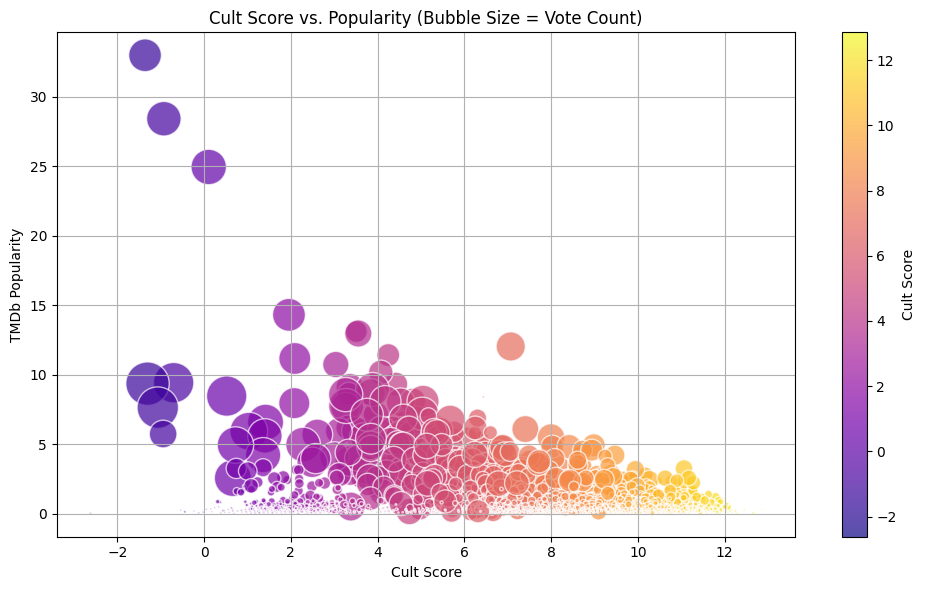

In [87]:
plot_cult_popularity_vote(df)

__Key Patterns Observed__
- Most cult films cluster in the low-to-mid popularity range (0 to 10)
This supports the idea that cult classics aren't driven by mainstream appeal or broad hype. They tend to attract niche attention.
- Cult Scores primarily range between 0 and 6
A few outliers push closer to 10 or 12, indicating strong cult appeal despite limited recognition on TMDb.
- Bubble size reflects vote count
Larger bubbles appear mostly in the lower Cult Score region, meaning popular films with many votes often aren't considered cult. Films with high Cult Scores usually have smaller vote counts, suggesting a devoted but limited fanbase.
- Color gradient reinforces the contrast
Purple tones represent lower Cult Scores, while yellows highlight higher ones. The spread shows no strong correlation between popularity and cult status; if anything, there may be a subtle inverse relationship.


__Now I'd like to compare that to the popularity vs. vote count without the cult score__

In [89]:
def plot_popularity_vs_votes(df):
    """
    Scatter plot: Popularity vs. Vote Count
    """
    plt.figure(figsize=(10,6))
    scatter = plt.scatter(
        df['popularity'],
        df['vote_count'],
        s=40,
        alpha=0.6,
        edgecolors='w',
        c='skyblue'
    )
    plt.xlabel('TMDb Popularity')
    plt.ylabel('Vote Count')
    plt.title('TMDb Popularity vs. Vote Count')
    plt.grid(True)
    plt.tight_layout()
    plt.show()


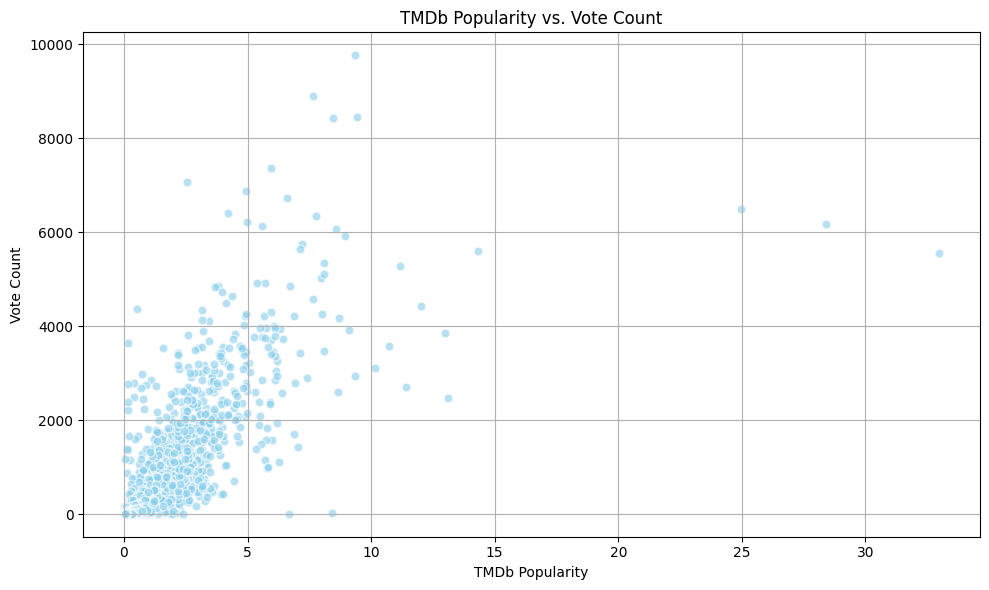

In [90]:
plot_popularity_vs_votes(df)

### Key Observations

- Most movies are clustered in the bottom left, where both popularity and vote count are low. That tells us most of the dataset consists of modest releases with limited audience interaction.
- There’s a visible trend. As popularity increases, vote count tends to rise with it. That tracks with what you’d expect if buzz leads to more views and ratings.
- A few films stand out with high vote counts and low popularity. These might be underground hits or fan-driven titles that earned strong engagement despite flying under the radar.
- There are also popular films with surprisingly low vote counts. Maybe they caught attention but didn’t leave enough impact for people to rate them.
- Very few films cross the 6,000-vote mark. Those that do are clear exceptions and likely had broader appeal or enduring attention.


# What We’re Seeing from Both Graphs
The popularity versus vote count chart shows how widely a film is noticed and how actively viewers respond to it. Most movies sit in the lower left corner, which means they’re not getting much buzz or engagement. There’s a clear upward trend. As popularity grows, vote count usually follows. That makes sense.

What’s more interesting are the ones that break the pattern. Some movies have low popularity but high vote counts. That suggests they might be underrated favorites with loyal fans. Others show the opposite. They’re popular but didn’t receive many ratings, which could mean they made a splash without leaving a strong impression.

The cult score versus popularity chart shifts the perspective. Instead of reach, it shows depth. Films with strong cult scores usually don’t rank high in popularity. They’re not grabbing everyone’s attention, but the people who watch them are clearly invested. Even with fewer ratings, these titles earn recognition for how deeply they resonate.

Together, these visuals give us a clearer picture of audience impact. Popularity might bring attention, but it doesn’t guarantee connection. Cult favorites prove that a film doesn’t need mass appeal to matter. Sometimes a smaller, passionate response says more than thousands of casual views.


### Research Question 2  (Which actors appear the most in Cult Classic films?)

__Since I set up the threshold previously, I am going to reuse that and explode the actor list__


In [37]:
# Ensure 'cast_list' column is already parsed
cult_movies_exploded = cult_movies.explode('cast_list')

__Now I'm going to count the actors appearances in Cult Films and display the values with a bar graph__

In [45]:
actor_counts = cult_movies_exploded['cast_list'].value_counts()

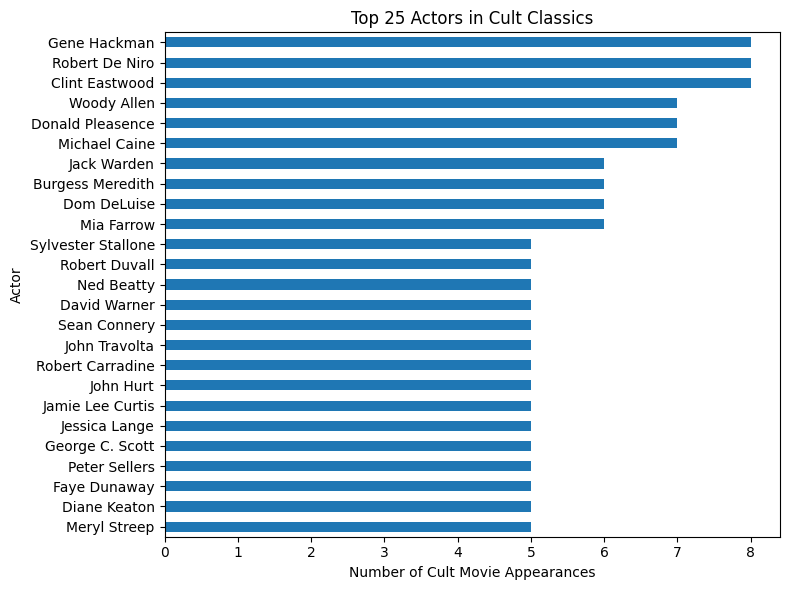

In [46]:
plot_horizontal_bar(
    data=actor_counts.head(25),
    title='Top 25 Actors in Cult Classics',
    xlabel='Number of Cult Movie Appearances',
    ylabel='Actor'
)



__Comparing that count vs the Full Dataset__

In [47]:
# Explode full dataset for normalization
df_exploded = df.explode('cast_list')

# Actor proportions in full dataset
full_actor_pct = df_exploded['cast_list'].value_counts(normalize=True)

# Actor proportions in cult dataset
cult_actor_pct = cult_movies_exploded['cast_list'].value_counts(normalize=True)

# Create a lift table containing pct scores for full and cult datasets
actor_lift = pd.DataFrame({
    'full_pct': full_actor_pct,
    'cult_pct': cult_actor_pct
})

#Calculate and display full and cult pct per actor sorted by lift value
actor_lift['lift'] = actor_lift['cult_pct'] / actor_lift['full_pct']
actor_lift = actor_lift.sort_values(by='lift', ascending=False)

actor_lift.head(50)


,full_pct,cult_pct,lift
Therese Giehse,0.000022,0.000439,20.056653
Jon Cypher,0.000022,0.000439,20.056653
John Limnidis,0.000022,0.000439,20.056653
John Lurie,0.000044,0.000878,20.056653
John Matshikiza,0.000022,0.000439,20.056653
John Milius,0.000022,0.000439,20.056653
John Mitchum,0.000022,0.000439,20.056653
John Philbin,0.000022,0.000439,20.056653
John Steadman,0.000022,0.000439,20.056653
John Thaw,0.000022,0.000439,20.056653


__I noticed that there were a lot of actors with the same lift value, so I dug into what I might have done wrong with the lift.__<br>
_I hypothesised that there were actors that had high scores due to low frequency. I decided to see if that was true._

In [31]:
# Combine raw counts and percentages for both datasets
full_actor_counts = df_exploded['cast_list'].value_counts()
cult_actor_counts = cult_movies_exploded['cast_list'].value_counts()

# Merge lift with raw counts
actor_lift_debug = actor_lift.copy()
actor_lift_debug['full_count'] = actor_lift_debug.index.map(full_actor_counts)
actor_lift_debug['cult_count'] = actor_lift_debug.index.map(cult_actor_counts)

# Flag actors with low frequency but high lift
suspicious_actors = actor_lift_debug[
    (actor_lift_debug['lift'] > 10) &
    ((actor_lift_debug['full_count'] <= 2) | (actor_lift_debug['cult_count'] <= 2))
]

suspicious_actors.sort_values(by='lift', ascending=False).head(20)


,full_pct,cult_pct,lift,full_count,cult_count
Therese Giehse,0.000022,0.000439,20.056653,1,1.0
Ricky Fataar,0.000022,0.000439,20.056653,1,1.0
Robbie Robertson,0.000022,0.000439,20.056653,1,1.0
Peter Boyden,0.000022,0.000439,20.056653,1,1.0
Peter Billingsley,0.000022,0.000439,20.056653,1,1.0
Peter Arne,0.000022,0.000439,20.056653,1,1.0
Perry King,0.000022,0.000439,20.056653,1,1.0
Oliver Clark,0.000022,0.000439,20.056653,1,1.0
Jon Cypher,0.000022,0.000439,20.056653,1,1.0
Otto Preminger,0.000022,0.000439,20.056653,1,1.0


__I decided to remove these actors to clean up the list__

In [32]:
# Map previous counts into new lift table
actor_lift_filtered = actor_lift.copy()
actor_lift_filtered['full_count'] = actor_lift_filtered.index.map(full_actor_counts)
actor_lift_filtered['cult_count'] = actor_lift_filtered.index.map(cult_actor_counts)

# Filter out low-frequency actors (e.g., appearing 2 or fewer times in either dataset)
actor_lift_filtered = actor_lift_filtered[
    (actor_lift_filtered['full_count'] > 2) &
    (actor_lift_filtered['cult_count'] > 2)
]

# Sort by lift, descending
actor_lift_filtered = actor_lift_filtered.sort_values(by='lift', ascending=False)

# Preview the top results
actor_lift_filtered.head(20)


,full_pct,cult_pct,lift,full_count,cult_count
P.J. Soles,0.000066,0.001318,20.056653,3,3.0
Melinda Dillon,0.000088,0.001318,15.042490,4,3.0
John Houseman,0.000088,0.001318,15.042490,4,3.0
Richard Dysart,0.000088,0.001318,15.042490,4,3.0
Teri Garr,0.000131,0.001757,13.371102,6,4.0
Sondra Locke,0.000131,0.001757,13.371102,6,4.0
Bill McKinney,0.000131,0.001757,13.371102,6,4.0
R. G. Armstrong,0.000131,0.001757,13.371102,6,4.0
Dabney Coleman,0.000175,0.002196,12.535408,8,5.0
Richard Jordan,0.000109,0.001318,12.033992,5,3.0


__This list feels much better and I decided to base my observations on it.__

#### Actor Presence in Cult Films: Key Observations
- High-lift actors aren’t mainstream stars but rather familiar character actors and supporting performers. Names like P.J. Soles, Dabney Coleman, and R.G. Armstrong consistently show up in cult-associated titles despite appearing infrequently in the full dataset.
- Lift values above 10 tend to reflect modest but repeated appearances in cult-classified films. For instance, P.J. Soles appears just three times overall, yet all three are cult titles — which drives her lift score significantly higher.
- The data favors actors connected to stylistic niches or genre signatures. Teri Garr, Michael Palin, and Griffin Dunne are associated with surreal, offbeat, or genre-blending projects that perform well in cult scoring.
- Actors with 5–9 cult appearances, like Dabney Coleman and Robert Carradine, appear to be consistent contributors to cult film culture. Their presence may be linked to specific decades, recurring character types, or tonal styles embraced by cult audiences.
- The list includes genre-crossers and cult specialists, implying that cult status isn’t tied to one genre alone. Actors whose filmography spans horror, satire, sci-fi, and experimental storytelling seem to have stronger cult traction.


__Bonus: For fun I wanted to see if `Bruce Campbell` had any movies in the list.  He's my favorite 'cult classic' actor and I was curious about his stats and ranking.__

In [48]:
# Filter for Bruce Campbell in cult dataset
bruce_cult_films = cult_movies_exploded[cult_movies_exploded['cast_list'].str.contains('Bruce Campbell', case=False, na=False)]
bruce_cult_titles = bruce_cult_films['original_title'].drop_duplicates()

# Filter for Bruce Campbell in full dataset
bruce_films = df_exploded[df_exploded['cast_list'].str.contains('Bruce Campbell', case=False, na=False)]
bruce_titles = bruce_films['original_title'].drop_duplicates()

# Count and rank
actor_counts = df_exploded['cast_list'].value_counts()
bruce_count = actor_counts.get('Bruce Campbell', 0)
bruce_rank = actor_counts.rank(ascending=False, method='min').get('Bruce Campbell', None)

# Display results
print("Bruce Campbell appears in the following cult classics:")
print(bruce_cult_titles.tolist())

print("\nBruce Campbell appears in the following films overall:")
print(bruce_titles.tolist())

print(f"\nBruce Campbell appears in {bruce_count} films total.")
print(f"Bruce Campbell ranks #{int(bruce_rank)} among all actors by appearance count.")


Bruce Campbell appears in the following cult classics:
['The Evil Dead', 'Evil Dead II']

Bruce Campbell appears in the following films overall:
['The Escort', 'Burn Notice: The Fall of Sam Axe', 'Serving Sara', 'Bubba Ho-tep', 'The Love Bug', "McHale's Navy", 'Man with the Screaming Brain', 'Alien Apocalypse', 'The Ant Bully', 'Aqua Teen Hunger Force Colon Movie Film for Theaters', 'My Name Is Bruce', 'Army of Darkness', 'The Evil Dead', 'Intruder', 'Maniac Cop', 'Evil Dead II', 'Maniac Cop 2']

Bruce Campbell appears in 17 films total.
Bruce Campbell ranks #388 among all actors by appearance count.


<a id='conclusions'></a>
## Conclusions

### Summary of Findings
This analysis set out to explore two questions: which genres are most strongly associated with cult films, and which actors appear most frequently in cult classics. To answer the first, I built a genre lift table that compares how often each genre appears in cult-classified films versus the broader dataset. Lift scores helped highlight genres that are overrepresented among cult titles, controlling for their base frequency. <br>  
    
Contrary to my initial expectations, horror and science fiction were not the most lifted genres. Instead, music, history, and war scored significantly higher. This suggests that cult status may be more closely tied to themes like performance, reinterpretation of real events, or emotionally intense storytelling than to traditional genre labels. <br>

For the second question, I performed a similar lift analysis on actors. To avoid misleading results from low-frequency names, I filtered out actors who appeared only once or twice. This helped surface recurring contributors such as P.J. Soles, Dabney Coleman, and Michael Palin. These performers aren’t top-billed stars but show consistent presence in cult-scoring titles, often through eccentric or genre-defining roles. <br>

This work was purely exploratory and does not include statistical testing. No causal relationships are implied, and all findings are observational. One limitation is that the analysis relies entirely on proportional metrics and may overlook deeper film-level patterns such as character type, dialogue style, or audience reception. Additionally, although I considered analyzing keywords, I limited the scope to genres and actors due to time constraints. <br>

External resources such as Wikipedia, IMDb, and Google were used throughout the project to help define “cult classics” and refine the Cult Score formula. These references provided grounding for which titles and contributors are typically cited in cult film discussions.

Future work could expand the analysis by incorporating time periods, tagline trends, or viewer ratings to enrich our understanding of cult appeal. Overall, the findings offer new perspectives on the kinds of stories and performers that drive enduring niche fandom.
    

In [34]:
# Running this cell will execute a bash command to convert this notebook to an .html file
!python -m nbconvert --to html Investigate_a_Dataset.ipynb

[NbConvertApp] Converting notebook Investigate_a_Dataset.ipynb to html
[NbConvertApp] WARNING | Alternative text is missing on 1 image(s).
[NbConvertApp] Writing 432760 bytes to Investigate_a_Dataset.html
